In [1]:
data_path = '/content/drive/MyDrive/Colab Notebooks/train_data'

In [3]:
with open(data_path, 'r', encoding='utf-8') as f:
  lines = f.read().split('\n')

In [4]:
import re
from collections import Counter

vocab = Counter()
sentences = []
sentence = []
ner_set = set()

for line in lines:
  if len(line) == 0 or line[0] == '\n':
    if len(sentence) > 0:
      sentences.append(sentence)
      sentence = []
    continue

  splits = line.split('\t')
  splits[-1] = re.sub(r'\n', '', splits[-1])
  word = splits[1]
  vocab[word] += 1

  sentence.append([word, splits[-1]])

  ner_set.add(splits[-1])

In [5]:
vocab

Counter({'두개': 11,
         '두판': 11,
         '라지': 11,
         '레귤러': 55,
         '먹고싶어': 11,
         '사이다': 33,
         '주문': 33,
         '주문할게요': 11,
         '주문할래': 33,
         '주세요': 22,
         '추가': 22,
         '콜라': 33,
         '피자': 88,
         '한개': 11,
         '한판': 11})

In [6]:
ner_set

{'-', 'menu', 'quantity', 'side-menu', 'size'}

In [7]:
print('number of sampes: ', len(sentences))
print('number of unique input tokens:', len(vocab))
print('number of unique output labels:' , len(ner_set))
print('max seq length for inputs: ', max([len(sentence) for sentence in sentences]))

number of sampes:  152
number of unique input tokens: 15
number of unique output labels: 5
max seq length for inputs:  5


In [8]:
vocab_sorted = sorted(vocab.items(), key=lambda x:x[1], reverse=True)

In [9]:
vocab_sorted

[('피자', 88),
 ('레귤러', 55),
 ('주문', 33),
 ('주문할래', 33),
 ('콜라', 33),
 ('사이다', 33),
 ('주세요', 22),
 ('추가', 22),
 ('한개', 11),
 ('두개', 11),
 ('라지', 11),
 ('주문할게요', 11),
 ('한판', 11),
 ('두판', 11),
 ('먹고싶어', 11)]

In [10]:
word_to_index = { w : i + 2 for i, (w, n) in enumerate(vocab_sorted) }
word_to_index['PAD'] = 0
word_to_index['OOV'] = 1

In [11]:
ner_to_index = {}
ner_to_index['PAD'] = 0

i = 1
for ner in ner_set:
  ner_to_index[ner] = i
  i += 1

In [12]:
ner_to_index

{'-': 5, 'PAD': 0, 'menu': 1, 'quantity': 2, 'side-menu': 4, 'size': 3}

In [16]:
# word_to_index.get => 1
# sentences 순회
# data_x 
data_x = []

for s in sentences:
  tmp_x = []
  for word, label in s:
    tmp_x.append(word_to_index.get(word, 1))
  data_x.append(tmp_x)



In [18]:
data_y = []

for s in sentences:
  tmp_y = []
  for word, label in s:
    tmp_y.append(ner_to_index.get(label))

  data_y.append(tmp_y)

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

num_sequence=8

pad_x = pad_sequences(data_x, padding='post', maxlen=num_sequence)
pad_y = pad_sequences(data_y, padding='post', maxlen=num_sequence)
pad_y = to_categorical(pad_y)

In [23]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(pad_x, pad_y,
                                                                    test_size=.2)

In [25]:
import json
with open('./assets/input_token_index.json', 'w') as fp:
  json.dump(word_to_index, fp)
with open('./assets/output_label_index.json', 'w') as fp:
  json.dump(ner_to_index, fp)
with open('./assets/model_parameter.json', 'w') as fp:
  json.dump({
      'num_input_tokens' : len(word_to_index),
      'num_output_labels' : len(ner_to_index),
      'embedding_dim' : 16,
      'hidden_units' : 32,
      'num_sequences' : 8
  }, fp)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed

def create_model(num_input_tokens, embedding_dim, num_sequence, num_labels, num_units):
  model = Sequential([
    Embedding(input_dim=num_input_tokens,
              output_dim=embedding_dim,
              input_length=num_sequence),
    Bidirectional(LSTM(num_units, return_sequences=True)),
    TimeDistributed(Dense(num_labels, activation='softmax'))
  ])

  return model

In [29]:
ner_model = create_model(len(word_to_index), 16, num_sequence, len(ner_to_index), 32)

In [31]:
ner_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 16)             272       
_________________________________________________________________
bidirectional (Bidirectional (None, 8, 64)             12544     
_________________________________________________________________
time_distributed (TimeDistri (None, 8, 6)              390       
Total params: 13,206
Trainable params: 13,206
Non-trainable params: 0
_________________________________________________________________


In [32]:
ner_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [35]:
history = ner_model.fit(train_data, train_labels,
              epochs=50, 
              batch_size=64,
              validation_split=.2)

Epoch 1/50
2/2 [==============================] - 0s 27ms/step - loss: 0.5654 - accuracy: 0.8112 - val_loss: 0.4979 - val_accuracy: 0.8700
Epoch 2/50
2/2 [==============================] - 0s 14ms/step - loss: 0.5572 - accuracy: 0.8281 - val_loss: 0.4891 - val_accuracy: 0.8700
Epoch 3/50
2/2 [==============================] - 0s 15ms/step - loss: 0.5484 - accuracy: 0.8281 - val_loss: 0.4803 - val_accuracy: 0.8700
Epoch 4/50
2/2 [==============================] - 0s 14ms/step - loss: 0.5397 - accuracy: 0.8281 - val_loss: 0.4713 - val_accuracy: 0.8700
Epoch 5/50
2/2 [==============================] - 0s 14ms/step - loss: 0.5309 - accuracy: 0.8281 - val_loss: 0.4620 - val_accuracy: 0.8700
Epoch 6/50
2/2 [==============================] - 0s 13ms/step - loss: 0.5217 - accuracy: 0.8281 - val_loss: 0.4526 - val_accuracy: 0.8700
Epoch 7/50
2/2 [==============================] - 0s 13ms/step - loss: 0.5125 - accuracy: 0.8294 - val_loss: 0.4429 - val_accuracy: 0.8750
Epoch 8/50
2/2 [===========

In [36]:
ner_model.evaluate(test_data, test_labels)

1/1 [==============================] - 0s 1ms/step - loss: 0.1743 - accuracy: 0.9556


[0.17434559762477875, 0.9556451439857483]

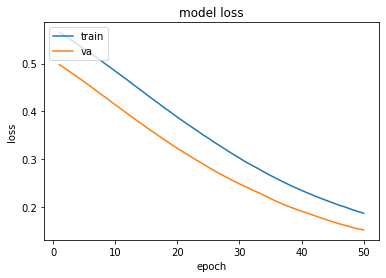

In [38]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'va'], loc='upper left')

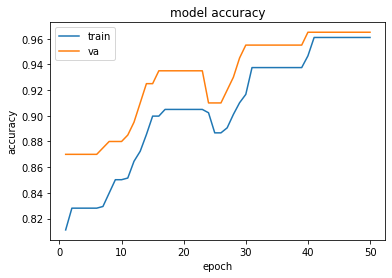

In [39]:

epochs = range(1, len(history.history['val_accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'va'], loc='upper left')

In [40]:
import numpy as np

index_to_word = {}
for k,v in word_to_index.items():
  index_to_word[v] = k

index_to_ner = {}
for k,v in ner_to_index.items():
  index_to_ner[v] = k

In [45]:
for i in range(0, 30):

  y_predict = ner_model.predict(np.array([test_data[i]]))
  y_predict = np.argmax(y_predict, axis=-1)
  sol = np.argmax(test_labels[i], -1)

  print ('{:15}|{:5}|{}'.format('단어','실제값','예측값'))
  print(35 * '-')

  for w, t, pred in zip(test_data[i], sol, y_predict[0]):
    if w != 0:
      print('{:17}: {:7} {}'.format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
콜라               : side-menu side-menu
주문할래             : -       -
단어             |실제값  |예측값
-----------------------------------
피자               : menu    menu
레귤러              : size    size
주문할게요            : -       -
단어             |실제값  |예측값
-----------------------------------
피자               : menu    menu
레귤러              : size    size
한개               : quantity -
단어             |실제값  |예측값
-----------------------------------
피자               : menu    menu
레귤러              : size    size
두개               : quantity -
단어             |실제값  |예측값
-----------------------------------
피자               : menu    side-menu
주문할래             : -       -
단어             |실제값  |예측값
-----------------------------------
피자               : menu    menu
레귤러              : size    size
주문할게요            : -       -
단어             |실제값  |예측값
-----------------------------------
사이다              : side-menu side-menu
추가               : 

In [46]:
ner_model.save('./assets/ner_model.h5')